In [964]:
## Imports
import pandas as pd
import numpy as np
import seaborn as sns

In [965]:
# Read the 2015 csv and translate the column names from German to English via google translate and Kaggle notes.
# https://www.kaggle.com/datasets/kmader/dogs-of-zurich?resource=download&select=zuordnungstabellehunderassehundetyp.csv
df_2015 = pd.read_csv('20151001hundehalter.csv')
df_2015.columns, df_2015.shape

(Index(['HALTER_ID', 'ALTER', 'GESCHLECHT', 'STADTKREIS', 'STADTQUARTIER',
        'RASSE1', 'RASSE1_MISCHLING', 'RASSE2', 'RASSE2_MISCHLING', 'RASSENTYP',
        'GEBURTSJAHR_HUND', 'GESCHLECHT_HUND', 'HUNDEFARBE'],
       dtype='object'),
 (6980, 13))

In [966]:
# German to English translations for column names
df_2015.columns = ['HOLDER_ID', 'AGE', 'GENDER', 'URBAN_CIRCLE', 'CITY_QUARTER',
    'BREED1', 'BREED1_HYBRID', 'BREED2', 'BREED2_HYBRID', 'BREED_TYPE',
    'BIRTH_YEAR_DOG', 'GENDER_DOG', 'COLOR_DOG']

# View updated column names
df_2015.head()

,HOLDER_ID,AGE,GENDER,URBAN_CIRCLE,CITY_QUARTER,BREED1,BREED1_HYBRID,BREED2,BREED2_HYBRID,BREED_TYPE,BIRTH_YEAR_DOG,GENDER_DOG,COLOR_DOG
0,126,51-60,m,9.0,92.0,Welsh Terrier,NaN,NaN,NaN,K,2011,w,schwarz/braun
1,574,61-70,w,2.0,23.0,Cairn Terrier,NaN,NaN,NaN,K,2002,w,brindle
2,695,41-50,m,6.0,63.0,Labrador Retriever,NaN,NaN,NaN,I,2012,w,braun
3,893,61-70,w,7.0,71.0,Mittelschnauzer,NaN,NaN,NaN,I,2010,w,schwarz
4,1177,51-60,m,10.0,102.0,Shih Tzu,NaN,NaN,NaN,K,2011,m,schwarz/weiss


2. Let's look closer at columns and do some data cleaning.

In [967]:
# For brevity, these text columns had some nan's that will be filled with 'Not listed"
df_2015['BREED1_HYBRID'] = df_2015['BREED1_HYBRID'].fillna('not_listed')
df_2015['BREED_TYPE'] = df_2015['BREED_TYPE'].fillna('not_listed')
df_2015['BREED1'] = df_2015['BREED1'].fillna('not_listed')
df_2015['BREED2'] = df_2015['BREED2'].fillna('not_listed')
df_2015['COLOR_DOG'] = df_2015['COLOR_DOG'].fillna('not_listed')

In [968]:
print(df_2015['AGE'].unique())
print(df_2015['GENDER'].unique())

# Owner age is of key interest so let's drop two nan rows.
df_2015.dropna(subset=['AGE'], inplace=True)

['51-60' '61-70' '41-50' '71-80' '31-40' '81-90' '21-30' '91-100' nan
 '11-20']
['m' 'w']


In [969]:
print(df_2015['URBAN_CIRCLE'].unique())
print(df_2015['CITY_QUARTER'].unique())

# Urban circle and city quarter fill nan with not_listed, after cast to string.
df_2015 = df_2015.astype({'URBAN_CIRCLE':'str','CITY_QUARTER':'str'})
df_2015['URBAN_CIRCLE'] = df_2015['URBAN_CIRCLE'].fillna('not_listed')
df_2015['CITY_QUARTER'] = df_2015['CITY_QUARTER'].fillna('not_listed')

[ 9.  2.  6.  7. 10.  3. 11.  8.  5.  4. nan 12.  1.]
[ 92.  23.  63.  71. 102.  34. 111.  21.  81.  91.  74.  52.  42.  82.
  51.  72. 119. 101.  61.  nan 122.  41.  33.  31.  24.  73. 121.  44.
 123.  83. 115.  14.  11.  13.   4.  12.   6.]


In [970]:
print(df_2015['BREED2_HYBRID'].unique())
# Breed 2 Hybrid column is only nan, so let's drop it.
df_2015.drop(['BREED2_HYBRID'], axis=1, inplace=True)

[nan]


In [971]:
print(df_2015['BIRTH_YEAR_DOG'].unique())

# In birth year dog we have four cases to address 8, 1, 5012, and 2016.
# The first two will be considered the dog's age, we will subtract that number from 2015 to obtain the birth year.
# The last two are harder to determine and will be dropped.
# Lastly 1962 and 1980 are impossible for dog birth years recorded in 2015 and will be dropped (Oldest verified dog ever was 29 years old).

df_2015.loc[(df_2015['BIRTH_YEAR_DOG']==8),'BIRTH_YEAR_DOG']=2015-8
df_2015.loc[(df_2015['BIRTH_YEAR_DOG']==1),'BIRTH_YEAR_DOG']=2015-1
df_2015.drop(df_2015.loc[(df_2015['BIRTH_YEAR_DOG']==5012) | (df_2015['BIRTH_YEAR_DOG']==2016)\
    | (df_2015['BIRTH_YEAR_DOG']==1962) | (df_2015['BIRTH_YEAR_DOG']==1980)].index, inplace=True)

# We will then create a column for the age of the dogs, a more useful continuous variable than birth year.
df_2015['AGE_DOG'] = 2015-df_2015['BIRTH_YEAR_DOG']
print(df_2015['AGE_DOG'].unique())

[2011 2002 2012 2010 2005 2004 2001 2013 2014 2007 2003 1999 2000 2009
 1997 2008 2006 2015 1998 1995 1980    8    1 1994 1962 5012 2016 1996]
[ 4 13  3  5 10 11 14  2  1  8 12 16 15  6 18  7  9  0 17 20 21 19]


Interesting questions this data could answer...

3. Based on the breed(s), birth year, and gender of the dog can we predict the age, gender, and location of the owner?

4. Can we do this in reverse? Will information about the owner's age, gender, and location reliably tell us information about the dog?

In [972]:
import category_encoders as ce
## ENCODE ALL CATEGORICAL VARIABLES

# One hot encode features with low cardinality
oh_encode = ce.one_hot.OneHotEncoder(cols=['GENDER', 'BREED_TYPE', 'BREED1_HYBRID', 'GENDER_DOG'], use_cat_names=True)
df_enc = oh_encode.fit_transform(df_2015)
print(df_enc.columns)

# Ordinally encode owner age for a new target variable, owner decades old.
# https://contrib.scikit-learn.org/category_encoders/ordinal.html
df_enc['DECADES_OLD'] = df_enc['AGE']
ordinal_encode = ce.ordinal.OrdinalEncoder(mapping= [{'col': 'DECADES_OLD',\
    'mapping': {'11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4, '51-60': 5,\
    '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9}}],\
    cols='DECADES_OLD')
df_enc = ordinal_encode.fit_transform(df_enc)


# We will need to address high cardinality of our features with some encoding.
print(len(df_enc['URBAN_CIRCLE'].unique()))
print(len(df_enc['CITY_QUARTER'].unique()))
print(len(df_enc['BREED1'].unique()))
print(len(df_enc['BREED2'].unique()))
print(len(df_enc['COLOR_DOG'].unique()))
df_enc.shape

Index(['HOLDER_ID', 'AGE', 'GENDER_m', 'GENDER_w', 'URBAN_CIRCLE',
       'CITY_QUARTER', 'BREED1', 'BREED1_HYBRID_not_listed',
       'BREED1_HYBRID_Mischling', 'BREED2', 'BREED_TYPE_K', 'BREED_TYPE_I',
       'BREED_TYPE_II', 'BREED_TYPE_not_listed', 'BIRTH_YEAR_DOG',
       'GENDER_DOG_w', 'GENDER_DOG_m', 'COLOR_DOG', 'AGE_DOG'],
      dtype='object')
13
37
301
118
169


(6974, 20)

In [973]:
# Adapted from: https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition
# Removing categorical values that occur very rarely.
df_new = df_enc.groupby('URBAN_CIRCLE').filter(lambda x : len(x)>1) # cities that appear more than 1 time(s)
df_new = df_new.groupby('CITY_QUARTER').filter(lambda x : len(x)>16) # districts that appear more than 16 time(s)
df_new = df_new.groupby('BREED1').filter(lambda x : len(x)>7) # primary breeds that appear more than 7 time(s)
df_new = df_new.groupby('BREED2').filter(lambda x : len(x)>4) # secondary breeds that appear more than 4 time(s)
df_new = df_new.groupby('COLOR_DOG').filter(lambda x : len(x)>12) # colors that appear more than 12 time(s)

print(len(df_new['URBAN_CIRCLE'].unique()))
print(len(df_new['CITY_QUARTER'].unique()))
print(len(df_new['BREED1'].unique()))
print(len(df_new['BREED2'].unique()))
print(len(df_new['COLOR_DOG'].unique()))
df_new.shape

12
32
128
31
63


(5934, 20)

In [974]:
# Encoder documentation: https://contrib.scikit-learn.org/category_encoders/hashing.html
# This section creates a hash encoder for each high cardinality feature, and generates 4-7 hash encoded columns for each.
# The number of hash encoded columns dependds on binary digits to reach number of unique values shown printed above.
hash_encode_urb= ce.hashing.HashingEncoder(n_components=4, cols=['URBAN_CIRCLE'])
df_new = hash_encode_urb.fit_transform(df_new)
df_new.rename(columns={'col_0':'city_hash_0', 'col_1':'city_hash_1', 
    'col_2':'city_hash_2', 'col_3':'city_hash_3'}, inplace=True)

hash_encode_qrt= ce.hashing.HashingEncoder(n_components=5, cols=['CITY_QUARTER'])
df_new = hash_encode_qrt.fit_transform(df_new)
df_new.rename(columns={'col_0':'borough_hash_0', 'col_1':'borough_hash_1', 
    'col_2':'borough_hash_2', 'col_3':'borough_hash_3', 'col_4':'borough_hash_4'}, inplace=True)

hash_encode_br1= ce.hashing.HashingEncoder(n_components=7, cols=['BREED1'])
df_new = hash_encode_br1.fit_transform(df_new)
df_new.rename(columns={'col_0':'breed1_hash_0', 'col_1':'breed1_hash_1', 'col_2':'breed1_hash_2',
    'col_3':'breed1_hash_3', 'col_4':'breed1_hash_4', 'col_5':'breed1_hash_5', 'col_6':'breed1_hash_6'}, inplace=True)

hash_encode_br2= ce.hashing.HashingEncoder(n_components=5, cols=['BREED2'])
df_new = hash_encode_br2.fit_transform(df_new)
df_new.rename(columns={'col_0':'breed2_hash_0', 'col_1':'breed2_hash_1', 
    'col_2':'breed2_hash_2', 'col_3':'breed2_hash_3', 'col_4':'breed2_hash_4'}, inplace=True)

hash_encode_col= ce.hashing.HashingEncoder(n_components=6, cols=['COLOR_DOG'])
df_new = hash_encode_col.fit_transform(df_new)
df_new.rename(columns={'col_0':'color_hash_0', 'col_1':'color_hash_1', 'col_2':'color_hash_2',
    'col_3':'color_hash_3', 'col_4':'color_hash_4', 'col_5':'color_hash_5'}, inplace=True)
df_new.columns

Index(['color_hash_0', 'color_hash_1', 'color_hash_2', 'color_hash_3',
       'color_hash_4', 'color_hash_5', 'breed2_hash_0', 'breed2_hash_1',
       'breed2_hash_2', 'breed2_hash_3', 'breed2_hash_4', 'breed1_hash_0',
       'breed1_hash_1', 'breed1_hash_2', 'breed1_hash_3', 'breed1_hash_4',
       'breed1_hash_5', 'breed1_hash_6', 'borough_hash_0', 'borough_hash_1',
       'borough_hash_2', 'borough_hash_3', 'borough_hash_4', 'city_hash_0',
       'city_hash_1', 'city_hash_2', 'city_hash_3', 'HOLDER_ID', 'AGE',
       'GENDER_m', 'GENDER_w', 'BREED1_HYBRID_not_listed',
       'BREED1_HYBRID_Mischling', 'BREED_TYPE_K', 'BREED_TYPE_I',
       'BREED_TYPE_II', 'BREED_TYPE_not_listed', 'BIRTH_YEAR_DOG',
       'GENDER_DOG_w', 'GENDER_DOG_m', 'AGE_DOG', 'DECADES_OLD'],
      dtype='object')

In [975]:
# Verify binary for all hash encoding columns.
# Adapted from: https://stackoverflow.com/questions/72014533/is-the-hashingencoder-from-category-encoders-meant-to-be-used-over-multiple-vari
for c in ['color_hash_0', 'color_hash_1', 'color_hash_2', 'color_hash_3',
       'color_hash_4', 'color_hash_5', 'breed2_hash_0', 'breed2_hash_1',
       'breed2_hash_2', 'breed2_hash_3', 'breed2_hash_4', 'breed1_hash_0',
       'breed1_hash_1', 'breed1_hash_2', 'breed1_hash_3', 'breed1_hash_4',
       'breed1_hash_5', 'breed1_hash_6', 'borough_hash_0', 'borough_hash_1',
       'borough_hash_2', 'borough_hash_3', 'borough_hash_4', 'city_hash_0',
       'city_hash_1', 'city_hash_2', 'city_hash_3']:
    print(df_new[c].unique())

[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]


In [1041]:
from sklearn.model_selection import train_test_split

# This model will predict owner age from dog age, color, gender, breed(s), breed type, hybrid or not, city, and borough

X = df_new[['color_hash_0', 'color_hash_1', 'color_hash_2', 'color_hash_3',
       'color_hash_4', 'color_hash_5', 'breed2_hash_0', 'breed2_hash_1',
       'breed2_hash_2', 'breed2_hash_3', 'breed2_hash_4', 'breed1_hash_0',
       'breed1_hash_1', 'breed1_hash_2', 'breed1_hash_3', 'breed1_hash_4',
       'breed1_hash_5', 'breed1_hash_6', 'borough_hash_0', 'borough_hash_1',
       'borough_hash_2', 'borough_hash_3', 'borough_hash_4', 'city_hash_0',
       'city_hash_1', 'city_hash_2', 'city_hash_3', 'BREED1_HYBRID_not_listed',
       'BREED1_HYBRID_Mischling', 'BREED_TYPE_K', 'BREED_TYPE_I', 'BREED_TYPE_II',
       'BREED_TYPE_not_listed', 'GENDER_DOG_w', 'GENDER_DOG_m', 'AGE_DOG']]

'''
X = df_new[['BREED1_HYBRID_not_listed', 'BREED1_HYBRID_Mischling', 'BREED_TYPE_K',
       'BREED_TYPE_I', 'BREED_TYPE_II', 'BREED_TYPE_not_listed', 'GENDER_DOG_w',
       'GENDER_DOG_m', 'AGE_DOG']]
'''
y = df_new['GENDER_w']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [953]:
df_unused_cols = df_new[['HOLDER_ID', 'AGE', 'GENDER_m', 'GENDER_w', 'BIRTH_YEAR_DOG', 'DECADES_OLD']]

In [1040]:
#TRY OH ENCODE ALL?
#TOP 10 BREEDS?
#DROP SMALL GROUPS, OLD PEOPLE, RARE BREEDS

oh_encode = ce.one_hot.OneHotEncoder(cols=['GENDER', 'BREED_TYPE', 'BREED1_HYBRID', 'GENDER_DOG'], use_cat_names=True)
df_enc = oh_encode.fit_transform(df_2015)
print(df_enc.columns)

Index(['HOLDER_ID', 'AGE', 'GENDER_m', 'GENDER_w', 'URBAN_CIRCLE',
       'CITY_QUARTER', 'BREED1', 'BREED1_HYBRID_not_listed',
       'BREED1_HYBRID_Mischling', 'BREED2', 'BREED_TYPE_K', 'BREED_TYPE_I',
       'BREED_TYPE_II', 'BREED_TYPE_not_listed', 'BIRTH_YEAR_DOG',
       'GENDER_DOG_w', 'GENDER_DOG_m', 'COLOR_DOG', 'AGE_DOG'],
      dtype='object')


RandomForestClassifier(max_depth=5, n_estimators=10)


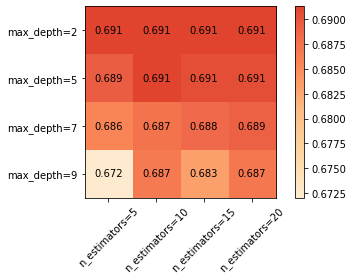

In [1042]:
# Grid Search from: https://stackoverflow.com/questions/38151615/specific-cross-validation-with-random-forest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn_evaluation import plot

# creating a RF classifier
clf = RandomForestClassifier()  

param_grid = {'n_estimators': [5,10,15,20], 'max_depth': [2, 5, 7, 9]}

grid_clf = GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

plot.grid_search(grid_clf.cv_results_, change=('n_estimators', 'max_depth'))
print(grid_clf.best_estimator_)


ACCURACY OF THE MODEL:  0.6878158338012352


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

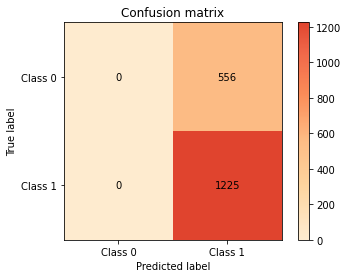

In [1043]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf = RandomForestClassifier(max_depth=2, n_estimators=5)
clf.fit(X_train, y_train)
  
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

from sklearn_evaluation import plot
plot.confusion_matrix(y_test, y_pred)